# Customer Segmentation logic 

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import joblib

### Load dataset

In [2]:
df = pd.read_csv("../data/processed/Customer_Segmentation/Customer_Segementation.csv")

In [3]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDateOnly
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2022-12-01
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2022-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2022-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2022-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2022-12-01
...,...,...,...,...,...,...,...,...,...,...
397879,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2023-12-09 12:50:00,0.85,12680.0,France,10.20,2023-12-09
397880,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2023-12-09 12:50:00,2.10,12680.0,France,12.60,2023-12-09
397881,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2023-12-09 12:50:00,4.15,12680.0,France,16.60,2023-12-09
397882,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2023-12-09 12:50:00,4.15,12680.0,France,16.60,2023-12-09


## Compute RFM Metrics 

In [4]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

recency_df = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
recency_df['Recency'] = (reference_date - recency_df['InvoiceDate']).dt.days
frequency_df = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
monetary_df = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary_df.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

### Check Skewness

In [5]:
print(rfm_df[['Recency', 'Frequency', 'Monetary']].skew())

Recency       1.246048
Frequency    12.067031
Monetary     19.324953
dtype: float64


### Log-transform the RFM features

In [6]:
rfm_log = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

In [7]:
print(rfm_log[['Recency', 'Frequency', 'Monetary']].skew())

Recency     -0.379169
Frequency    1.208652
Monetary     0.393553
dtype: float64


### Normalize the RFM values

In [8]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log[['Recency', 'Frequency', 'Monetary']])

### Determine optimal number of clusters (Elbow + Silhouette)

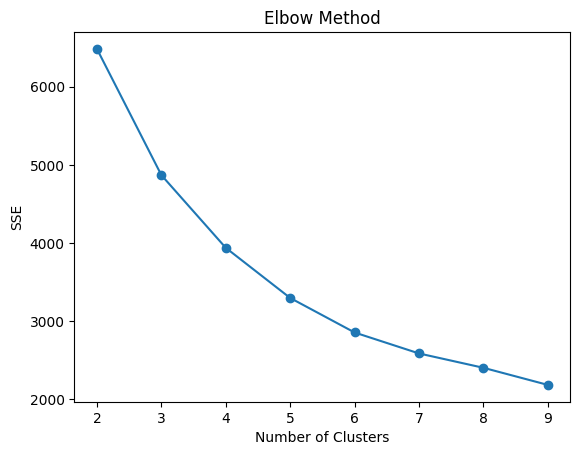

k=2 Silhouette Score: 0.4332
k=3 Silhouette Score: 0.3360
k=4 Silhouette Score: 0.3371
k=5 Silhouette Score: 0.3173
k=6 Silhouette Score: 0.3143
k=7 Silhouette Score: 0.2875
k=8 Silhouette Score: 0.2682
k=9 Silhouette Score: 0.2784


<Figure size 640x480 with 0 Axes>

In [9]:
# Elbow Method
sse = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 10), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()
plt.savefig("../visuals/Performance_Metrices/Customer_Segmentation/Elbow & Silhouette.png")

# Optional: Silhouette Score
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f'k={k} Silhouette Score: {score:.4f}')

### Cluster the customers

In [10]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_log['Cluster'] = kmeans.fit_predict(rfm_scaled)

### Interpret Clusters
#### Use groupby to check the average R, F, M per cluster:

In [11]:
cluster_profile = rfm_log.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print(cluster_profile)

          Recency  Frequency  Monetary
Cluster                               
0        2.701327   1.090700  6.091552
1        2.160515   2.478709  8.356989
2        4.015904   1.565575  7.251444
3        5.024273   0.814544  5.592418


### Vizualize Clusters

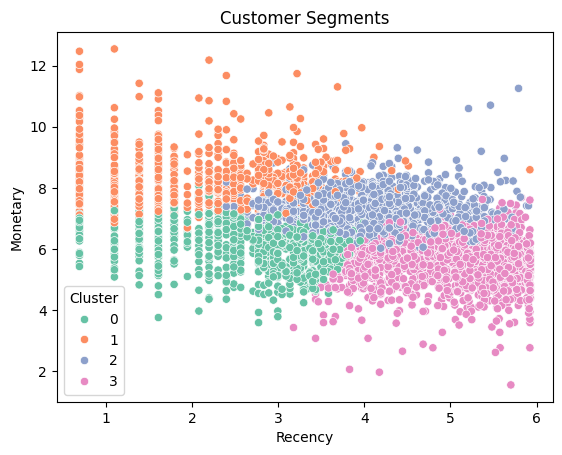

<Figure size 640x480 with 0 Axes>

In [12]:
sns.scatterplot(data=rfm_log, x='Recency', y='Monetary', hue='Cluster', palette='Set2')
plt.title('Customer Segments')
plt.show()
plt.savefig("../visuals/Performance_Metrices/Customer_Segmentation/Customer Segments.png")

# Save models

In [13]:
# joblib.dump(kmeans, '../models/kmeans_model.pkl')
# joblib.dump(scaler, '../models/scaler.pkl')

# ***Summary:***
### In the Customer Segmentation module of the Shopper Spectrum project, we performed RFM (Recency, Frequency, Monetary) analysis to understand customer purchasing behavior. We first computed the Recency (days since last purchase), Frequency (number of unique transactions), and Monetary (total spend) for each customer. Upon checking the skewness of these features, we found that all were highly right-skewed, especially Frequency and Monetary. To address this, we applied a log1p transformation, which significantly reduced skewness and normalized the distributions. Afterward, we standardized the transformed features using StandardScaler to prepare the data for clustering. We then applied the KMeans algorithm to group customers into four distinct behavioral clusters based on their RFM scores. Finally, we saved both the clustering model and the scaler, enabling integration with a Streamlit application for real-time customer segment prediction. This segmentation allows businesses to identify high-value, regular, occasional, and at-risk customers for targeted marketing strategies.

In [14]:
def assign_segment(row):
    if row['Cluster'] == 0:
        return 'High-Value'
    elif row['Cluster'] == 1:
        return 'At-Risk'
    elif row['Cluster'] == 2:
        return 'Occasional'
    else:
        return 'Regular'

rfm_log['Segment'] = rfm_log.apply(assign_segment, axis=1)

### Calinski-Harabasz Index
        - Ratio of between-cluster variance to within-cluster variance.

        - Higher is better

In [15]:
ch_score = calinski_harabasz_score(rfm_scaled, rfm_log['Cluster'])
print(f"Calinski-Harabasz Index: {ch_score:.2f}")

Calinski-Harabasz Index: 3328.99


### Davies-Bouldin Index
        - Measures cluster similarity (lower is better).

In [16]:
db_score = davies_bouldin_score(rfm_scaled, rfm_log['Cluster'])
print(f"Davies-Bouldin Index: {db_score:.4f}")

Davies-Bouldin Index: 1.0101


# Clustering Evaluation Results
## Calinski-Harabasz Index: 3328.99
- Interpretation: This is a very good score — it suggests that:

    - The clusters are well separated (high between-cluster variance),

    - and internally tight (low within-cluster variance).

- Rule of thumb: Higher is better — values above 500 are often considered strong. So 3328.99 is excellent.

## Davies-Bouldin Index: 1.0101
- Interpretation: Lower is better.

    - A value close to 1.0 is acceptable/good.

    - If DBI were < 0.7, it would be excellent, but 1.01 is still very reasonable.

- Rule of thumb:

    - < 0.5 = Excellent

    - ~0.5–1.0 = Good

    - 1.5 = Poor (overlapping clusters)

## Conclusion:
### Your clustering model is performing well:

- Tightly grouped clusters

- Good separation between them

- Stable enough to label and use in production (Streamlit ap

# ***Model Fine tunning***

In [22]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA

### Rfm_scaled: preprocessed RFM data (log-transformed & standardized)


===== KMeans =====
Silhouette Score      : 0.3371
Calinski-Harabasz     : 3328.99
Davies-Bouldin Index  : 1.0101

===== Agglomerative =====
Silhouette Score      : 0.2419
Calinski-Harabasz     : 2615.05
Davies-Bouldin Index  : 1.1200

===== DBSCAN =====
Silhouette Score      : 0.2662
Calinski-Harabasz     : 1265.64
Davies-Bouldin Index  : 1.5806

===== GMM =====
Silhouette Score      : 0.1739
Calinski-Harabasz     : 2154.68
Davies-Bouldin Index  : 1.7191


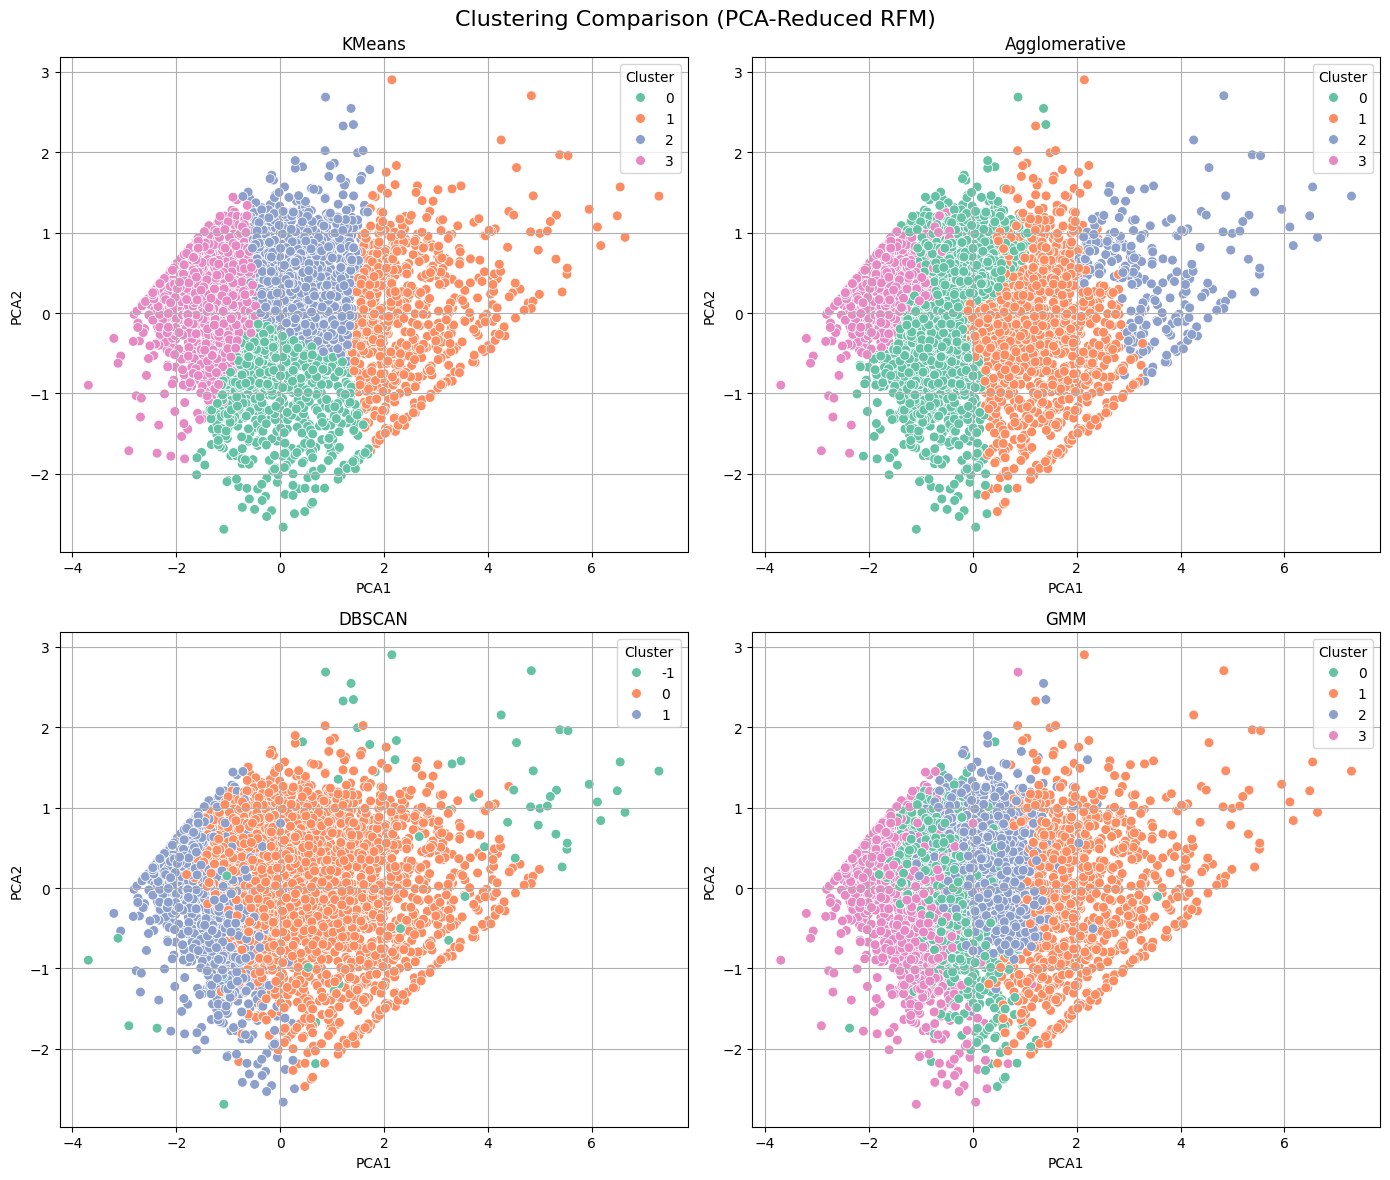

In [23]:
# Step 1: PCA for 2D visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Step 2: Define clustering models
models = {
    "KMeans": KMeans(n_clusters=4, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=4),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),  # you can tune eps
    "GMM": GaussianMixture(n_components=4, random_state=42)
}

# Step 3: Run models, evaluate and plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    print(f"\n===== {name} =====")

    # Fit & predict
    if name == "GMM":
        labels = model.fit_predict(rfm_scaled)
    else:
        labels = model.fit(rfm_scaled).fit_predict(rfm_scaled)

    # Handle noise in DBSCAN
    if len(set(labels)) < 2 or (len(set(labels)) == 2 and -1 in labels):
        print("Not enough clusters found. Skipping metrics.")
        sil_score = ch_score = db_score = "N/A"
    else:
        sil_score = silhouette_score(rfm_scaled, labels)
        ch_score = calinski_harabasz_score(rfm_scaled, labels)
        db_score = davies_bouldin_score(rfm_scaled, labels)

        print(f"Silhouette Score      : {sil_score:.4f}")
        print(f"Calinski-Harabasz     : {ch_score:.2f}")
        print(f"Davies-Bouldin Index  : {db_score:.4f}")

    # Plot
    df_plot = pd.DataFrame(rfm_pca, columns=['PCA1', 'PCA2'])
    df_plot['Cluster'] = labels

    sns.scatterplot(data=df_plot, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', ax=axes[i], s=50)
    axes[i].set_title(name)
    axes[i].legend(title='Cluster', loc='best')
    axes[i].grid(True)

plt.suptitle("Clustering Comparison (PCA-Reduced RFM)", fontsize=16)
plt.tight_layout()
plt.show()

### OVERALL KMEANS IS WORKING BEST